# 3 Decision-based Cascades: A Local Election

In [1]:
import snap
import matplotlib.pyplot as plt

# Setup
num_voters = 10000
decision_period = 10

## 3.1 Basic Setup and Forecasting

In [2]:
def read_graphs(path1, path2):
    """
    :param - path1: path to edge list file for graph 1
    :param - path2: path to edge list file for graph 2

    return type: snap.PUNGraph, snap.PUNGraph
    return: Graph 1, Graph 2
    """
    Graph1 = snap.LoadEdgeList(snap.PUNGraph, "graph1.txt", 0, 1)
    Graph2 = snap.LoadEdgeList(snap.PUNGraph, "graph2.txt", 0, 1)
    return Graph1, Graph2

In [3]:
def initial_voting_state(Graph):
    """
    Function to initialize the voting preferences.

    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: Python dictionary
    return: Dictionary mapping node IDs to initial voter preference
            ('A', 'B', or 'U')

    Note: 'U' denotes undecided voting preference.

    Example: Some random key-value pairs of the dict are
             {0 : 'A', 24 : 'B', 118 : 'U'}.
    """
    voter_prefs = {}
    for node in Graph.Nodes():
        node_id = node.GetId()
        if (node_id % 10) in (0, 1, 2, 3):
            voter_prefs[node_id] = 'A'
        elif (node_id % 10) in (4, 5, 6, 7):
            voter_prefs[node_id] = 'B'
        else:
            voter_prefs[node_id] = 'U'
    assert(len(voter_prefs) == num_voters)
    # print('initial:', voter_prefs)
    return voter_prefs

In [4]:
def iterate_voting(Graph, init_conf):
    """
    Function to perform the 10-day decision process.

    :param - Graph: snap.PUNGraph object representing an undirected graph
    :param - init_conf: Dictionary object containing the initial voting
                        preferences (before any iteration of the decision
                        process)

    return type: Python dictionary
    return: Dictionary containing the voting preferences (mapping node IDs to
            'A','B' or 'U') after the decision process.

    Hint: Use global variables num_voters and decision_period to iterate.
    """
    curr_conf = init_conf.copy()
    curr_alternating_vote = 'A'
    for epoch in range(decision_period):
        # voters are processed in increasing order of node ID
        for node_id in range(num_voters):
            # only the undicided voter go through the decision process
            if init_conf[node_id] != 'U':
                continue
            node = Graph.GetNI(node_id)
            counter = {'A': 0, 'B': 0, 'U': 0}
            
            for i in range(node.GetDeg()):
                counter[curr_conf[node.GetNbrNId(i)]] += 1
            if counter['A'] > counter['B']:
                curr_conf[node_id] = 'A'
            elif counter['B'] > counter['A']:
                curr_conf[node_id] = 'B'
            else:
                curr_conf[node_id] = curr_alternating_vote
                curr_alternating_vote = 'A' if curr_alternating_vote == 'B' else 'B'
    # print(curr_conf)
    return curr_conf

In [5]:
def sim_election(Graph):
    """
    Function to simulate the election process, takes the Graph as input and
    gives the final voting preferences (dictionary) as output.
    """
    init_conf = initial_voting_state(Graph)
    conf = iterate_voting(Graph, init_conf)
    return conf

In [6]:
def winner(conf):
    """
    Function to get the winner of election process.
    :param - conf: Dictionary object mapping node ids to the voting preferences

    return type: char, int
    return: Return candidate ('A','B') followed by the number of votes by which
            the candidate wins.
            If there is a tie, return 'U', 0
    """
    counter = {'A': 0, 'B': 0}
    for value in conf.values():
        counter[value] += 1
    if counter['A'] > counter['B']:
        return 'A', counter['A'] - counter['B']
    elif counter['B'] > counter['A']:
        return 'B', counter['B'] - counter['A']
    else:
        return 'U', 0

In [7]:
def Q1():
    print ("\nQ1:")
    Gs = read_graphs('graph1.txt', 'graph2.txt')    # List of graphs

    # Simulate election process for both graphs to get final voting preference
    final_confs = [sim_election(G) for G in Gs]

    # return final_confs
    # Get the winner of the election, and the difference in votes for both
    # graphs
    res = [winner(conf) for conf in final_confs]

    for i in range(2):
        print("In graph %d, candidate %s wins by %d votes" % (
                i+1, res[i][0], res[i][1]
        ))

In [8]:
Q1()


Q1:
In graph 1, candidate B wins by 96 votes
In graph 2, candidate B wins by 256 votes


## 3.2 TV Advertising

In [9]:
def Q2sim(Graph, k):
    """
    Function to simulate the effect of advertising.
    :param - Graph: snap.PUNGraph object representing an undirected graph
             k: amount to be spent on advertising

    return type: int
    return: The number of votes by which A wins (or loses), i.e. (number of
            votes of A - number of votes of B)

    Hint: Feel free to use initial_voting_state and iterate_voting functions.
    """
    init_conf = initial_voting_state(Graph)
    for i in range(3000, 3000 + k // 100):
        init_conf[i] = 'A'
    conf = iterate_voting(Graph, init_conf)
    counter = {'A': 0, 'B': 0}
    for value in conf.values():
        counter[value] += 1
    return counter['A'] - counter['B']

In [10]:
def find_min_k(diffs):
    """
    Function to return the minimum amount needed for A to win
    :param - diff: list of (k, diff), where diff is the value by which A wins
                   (or loses) i.e. (A-B), for that k.

    return type: int
    return: The minimum amount needed for A to win
    """
    for k, diff in diffs:
        if diff > 0:
            return k
    return 'more than %d' % diffs[-1][0]

In [11]:
def makePlot(res, title):
    """
    Function to plot the amount spent and the number of votes the candidate
    wins by
    :param - res: The list of 2 sublists for 2 graphs. Each sublist is a list
                  of (k, diff) pair, where k is the amount spent, and diff is
                  the difference in votes (A-B).
             title: The title of the plot
    """
    Ks = [[k for k, diff in sub] for sub in res]
    res = [[diff for k, diff in sub] for sub in res]
    for i in range(len(Ks)):
        plt.plot(Ks[i], res[i], label='Graph %d' % (i + 1))
    plt.plot(Ks[0], [0.0] * len(Ks[0]), ':', color='black')
    plt.xlabel('Amount spent ($)')
    plt.ylabel('#votes for A - #votes for B')
    plt.title(title)
    plt.legend()
    plt.show()

In [12]:
def Q2():
    print ("\nQ2:")
    # List of graphs
    Gs = read_graphs('graph1.txt', 'graph2.txt')

    # List of amount of $ spent
    Ks = [x * 1000 for x in range(1, 10)]

    # List of (List of diff in votes (A-B)) for both graphs
    res = [[(k, Q2sim(G, k)) for k in Ks] for G in Gs]

    # List of minimum amount needed for both graphs
    min_k = [find_min_k(diff) for diff in res]

    formatString = "On graph {}, the minimum amount you can spend to win is {}"
    for i in range(2):
        print(formatString.format(i + 1, min_k[i]))

    makePlot(res, 'TV Advertising')


Q2:
On graph 1, the minimum amount you can spend to win is 5000
On graph 2, the minimum amount you can spend to win is 7000


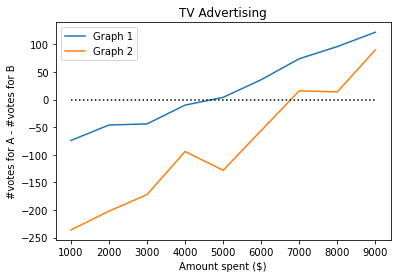

In [13]:
Q2()

## 3.3 Wining and Dining the High Rollers

In [14]:
def find_high_rollers(Graph):
    """
    Function to find nodes with highest degree, when there are ties between 
    voters with the same degree, the high roller with lowest node ID get 
    chosen first.
    :param - Graph: snap.PUNGraph object representing an undirected graph

    return type: Python list
    return: A list of node_id, from highest degree to lowest degree
    """
    id_degree_list = [(node_id, Graph.GetNI(node_id).GetDeg()) for node_id in range(num_voters)]
    # sorted function in Python is stable, so node with same degree will be sorted by id
    id_degree_list = sorted(id_degree_list, key=lambda x:-x[1])
    return [node_id for node_id, degree in id_degree_list]

In [15]:
def Q3sim(Graph, k):
    """
    Function to simulate the effect of a dining event.
    :param - Graph: snap.PUNGraph object representing an undirected graph
             k: amount to be spent on the dining event

    return type: int
    return: The number of votes by which A wins (or loses), i.e. (number of
            votes of A - number of votes of B)

    Hint: Feel free to use initial_voting_state and iterate_voting functions.
    """
    init_conf = initial_voting_state(Graph)
    high_rollers = find_high_rollers(Graph)
    for i in range(k // 1000):
        init_conf[high_rollers[i]] = 'A'
    conf = iterate_voting(Graph, init_conf)
    counter = {'A': 0, 'B': 0}
    for value in conf.values():
        counter[value] += 1
    return counter['A'] - counter['B']

In [16]:
def Q3():
    print ("\nQ3:")
    # List of graphs
    Gs = read_graphs('graph1.txt', 'graph2.txt')

    # List of amount of $ spent
    Ks = [x * 1000 for x in range(1, 10)]

    # List of (List of diff in votes (A-B)) for both graphs
    res = [[(k, Q3sim(G, k)) for k in Ks] for G in Gs]

    # List of minimum amount needed for both graphs
    min_k = [find_min_k(diff) for diff in res]

    formatString = "On graph {}, the minimum amount you can spend to win is {}"
    for i in range(2):
        print(formatString.format(i + 1, min_k[i]))

    makePlot(res, 'Wining and Dining')


Q3:
On graph 1, the minimum amount you can spend to win is more than 9000
On graph 2, the minimum amount you can spend to win is 6000


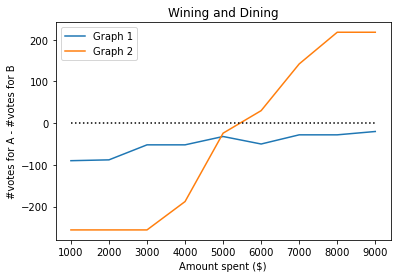

In [17]:
Q3()

## 3.4 Analysis


Q4:
	# Nodes	# Edges
Graph1	10000	100000
Graph2	10000	99900


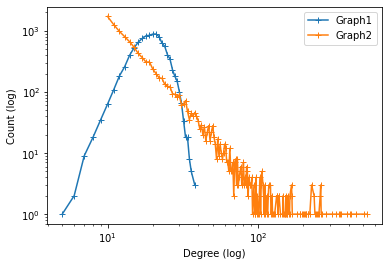

In [18]:
def Q4():
    """
    Function to plot the distributions of two given graphs on a log-log scale.
    """
    print ("\nQ4:")
    Gs = read_graphs('graph1.txt', 'graph2.txt')
    
    # graph statistics
    print('\t# Nodes\t# Edges')
    for i in range(2):
        print('Graph%d\t%d\t%d' % (i + 1, Gs[i].GetNodes(), Gs[i].GetEdges()))
    
    # degree distribution
    for i, G in enumerate(Gs):
        DegToCntV = snap.TIntPrV()
        snap.GetOutDegCnt(G, DegToCntV)
        degrees = [p.GetVal1() for p in DegToCntV if p.GetVal1() > 0]
        counts = [p.GetVal2() for p in DegToCntV if p.GetVal1() > 0]
        plt.plot(degrees, counts, '+-', label='Graph%d' % (i + 1))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log)')
    plt.ylabel('Count (log)')
    plt.legend()
    plt.show()
Q4()

It is true that both graphs have same number of nodes (10000) and approximately same number of edges (100000 v.s. 99900). However, there degree dictribution is different. 
- In Graph 1, no nodes have degree larger than 40 (when average degree is $2m/n = 20$). So selecting the high rollers will not have significantly better effects. And as it costs 10 times more to treat the high rollers, it cannot help Candidate A to win the election with limited campaign war chest. 
- However in Graph 2, some nodes have much higher degrees. They are the influencial people in the social network. So spending money on high rollers in Graph 2 has significantly better effect than doing that in Graph 1, and also has more influence than TV advertising. 

By the way, comparing the degree distribution plot to it in homework 1, problem 1. We find that graph 1 seems like to be an Erdos-Renyi random graph (or something similar), and graph 2 seems like to be a real social network. So in real life, maybe it is better to treat those high rollers. 